In [1]:
import qrandom
import torch 
from torch import tensor
import numpy as np
import torch.nn as nn
relu = nn.functional.relu
softmax = nn.functional.softmax
from torch.nn.functional import cross_entropy
from pathlib import Path
import os, shutil
from os import listdir
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from IPython.display import Audio
import random
import gc

In [ ]:
print(torch.cuda.current_device(),
torch.cuda.device(0),
torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [4]:
#noise_shape = (100,)
epochs = 50   #change to 150
lr = 2e-4
batch_size = 1 #change to 30 if possible
height = 577
length = 123
loss = nn.BCELoss()

In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(70971, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 70971)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(123, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 70971)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 577, 123)
        return nn.Tanh()(x)

In [ ]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

In [7]:
G = torch.load(r"C:\Users\g_bab\Downloads\saved_musicGAN\generator_epoch_1.pth")

In [ ]:
#credit to sbalian for qrandom

list_products = []
for i in range(100):                #first 100 melspecs (np arrays) in a list
    batch = []
    for i in range(batch_size):
        qrandomarray = np.zeros(123)
    
        #for q in range(577 * 123):
            #qrandomarray[q] = qrandom.random()
        for q in range(123):
            qrandomarray[q] = random.random()
        
        #qrandomarray = np.reshape(qrandomarray, (1, 123))
        qrandomarray = (qrandomarray - 0.5) / 0.5
        batch.append(qrandomarray)
    batch = np.stack(batch)
    batch = batch.astype(np.float32)
    batch = torch.from_numpy(batch)
    batch = batch.to(device)
    print(batch.shape)
    product = G(batch)
    print(product.shape)
    detached = product.to("cpu").detach().numpy()
    list_products.append(detached)
   

In [ ]:
print(list_products[].shape)

In [ ]:
list_amp_values = []
for melspec in list_products:
    for i in range(len(melspec[0])):
        audio_array = librosa.feature.inverse.mel_to_audio(melspec, sr = 16000)
        list_amp_values += list(audio_array)
playback = np.asarray(list_amp_values)

In [ ]:
list_amp_values = []
for melspec in list_products[:1]:
    for i in range(10):
        audio_array = librosa.feature.inverse.mel_to_audio(melspec[i], sr = 16000)
        list_amp_values += list(audio_array)
playback = np.asarray(list_amp_values)

In [14]:
playback = np.asarray(list_amp_values)
print(len(playback))

374784


In [15]:
Audio(playback, rate=44100)   

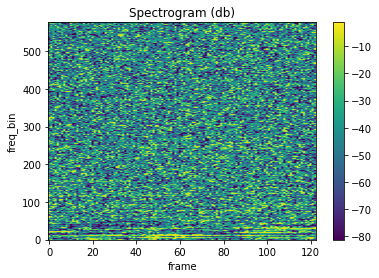

In [45]:
noise = np.random.rand(1,123)
noise = noise.astype(np.float32)
noise = torch.from_numpy(noise)
noise = noise.to(device)
fake_inputs = G(noise)
fake_inputs = fake_inputs.to("cpu").detach().numpy()
plot_spectrogram(fake_inputs[0])